In [72]:
import sympy
import matplotlib.pyplot as plt
import numpy as np
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data
import symfem

import matplotlib.colors as mcolors
from random import sample, choice
from tqdm import tqdm
from IPython.display import display
from utils import get_global_normals_and_tangentials, get_local_normals_and_tangentials, get_middle_indices

In [64]:
X, Y, x, y, x_1, y_1, x_2, y_2, x_3, y_3, p_1, p_2, p_3 = sympy.symbols("X Y x y x_1 y_1 x_2 y_2 x_3 y_3 p_1 p_2 p_3")

In [65]:
triangle_sym = np.array([
    [x_1, y_1],
    [x_2, y_2],
    [x_3, y_3],
    ])

In [66]:
BELL_BASIS = symfem.create_element("triangle", "Argyris", 5)
BELL_BASIS_reference = BELL_BASIS.get_basis_functions()
BELL_BASIS.get_basis_functions()[18] *= -1
BELL_BASIS.get_basis_functions()[20] *= -1

In [67]:
def transform_basis(trng_num, trng):
    
    MAP = BELL_BASIS.reference.get_map_to(triangle_sym)
    INV_MAP = BELL_BASIS.reference.get_inverse_map_to(triangle_sym)

    
    U = MAP[0].subs({x_1:trng[0, 0], x_2:trng[1, 0], x_3:trng[2, 0], 
                     y_1:trng[0, 1], y_2:trng[1, 1], y_3:trng[2, 1],})
    
    V = MAP[1].subs({x_1:trng[0, 0], x_2:trng[1, 0], x_3:trng[2, 0], 
                     y_1:trng[0, 1], y_2:trng[1, 1], y_3:trng[2, 1],})
    
    
    u = INV_MAP[0].subs({x_1:trng[0, 0], x_2:trng[1, 0], x_3:trng[2, 0], 
                         y_1:trng[0, 1], y_2:trng[1, 1], y_3:trng[2, 1],})
    
    v = INV_MAP[1].subs({x_1:trng[0, 0], x_2:trng[1, 0], x_3:trng[2, 0], 
                         y_1:trng[0, 1], y_2:trng[1, 1], y_3:trng[2, 1],})
    
            
    J = sympy.Matrix([u, v]).jacobian([x, y])
    
    THETA = sympy.Matrix([
        [u.diff(x)**2, 2*u.diff(x)*v.diff(x), v.diff(x)**2],
        [u.diff(y)*u.diff(x), u.diff(y)*v.diff(x)+u.diff(x)*v.diff(y), v.diff(x)*v.diff(y)],
        [u.diff(y)**2, 2*u.diff(y)*v.diff(y), v.diff(y)**2]
    ]).inv()

    
    l1 = (((x_2 - x_3)**2 + (y_2 - y_3)**2)**0.5).subs({x_1:trng[0, 0], x_2:trng[1, 0], x_3:trng[2, 0], 
                                                        y_1:trng[0, 1], y_2:trng[1, 1], y_3:trng[2, 1],
                                                       })
    
    l2 = (((x_1 - x_3)**2 + (y_1 - y_3)**2)**0.5).subs({x_1:trng[0, 0], x_2:trng[1, 0], x_3:trng[2, 0], 
                                                        y_1:trng[0, 1], y_2:trng[1, 1], y_3:trng[2, 1],
                                                       })
    
    l3 = (((x_1 - x_2)**2 + (y_1 - y_2)**2)**0.5).subs({x_1:trng[0, 0], x_2:trng[1, 0], x_3:trng[2, 0], 
                                                        y_1:trng[0, 1], y_2:trng[1, 1], y_3:trng[2, 1],
                                                       })
     
    
    n1 = sympy.Matrix(elem_normal[trng_num, 3])
    t1 = sympy.Matrix(elem_tangential[trng_num, 3])


    n2 = sympy.Matrix(elem_normal[trng_num, 4])
    t2 = sympy.Matrix(elem_tangential[trng_num, 4])

    
    n3 = sympy.Matrix(elem_normal[trng_num, 5])
    t3 = sympy.Matrix(elem_tangential[trng_num, 5])
        
        
    
    DN_n1 = sympy.Matrix(global_elem_normal[triangles[trng_num]][3])
    DN_t1 = sympy.Matrix(global_elem_tangential[triangles[trng_num]][3])


    DN_n2 = sympy.Matrix(global_elem_normal[triangles[trng_num]][4])
    DN_t2 = sympy.Matrix(global_elem_tangential[triangles[trng_num]][4])

    
    DN_n3 = sympy.Matrix(global_elem_normal[triangles[trng_num]][5])
    DN_t3 = sympy.Matrix(global_elem_tangential[triangles[trng_num]][5])
                
    
    G1 = sympy.Matrix([
        [*n1],
        [*t1]
    ])
    
    G2 = sympy.Matrix([
        [*n2],
        [*t2]
    ])
    
    G3 = sympy.Matrix([
        [*n3],
        [*t3]
    ])
    
    G1_hat = sympy.Matrix([
        [+np.sqrt(1/2), +np.sqrt(1/2)],
        [-np.sqrt(1/2), +np.sqrt(1/2)],
    ])
    
    G2_hat = sympy.Matrix([
        [-1, +0],
        [+0, -1],
    ])
    
    G3_hat = sympy.Matrix([
        [+0, -1],
        [+1, +0]
    ])

    
    B1 = G1_hat @ J.inv().T @ G1.T
    B2 = G2_hat @ J.inv().T @ G2.T
    B3 = G3_hat @ J.inv().T @ G3.T
    
    
    ## For DN  
    DN_G1 = sympy.Matrix([
        [*DN_n1],
        [*DN_t1]
    ])
    
    DN_G2 = sympy.Matrix([
        [*DN_n2],
        [*DN_t2]
    ])
    
    DN_G3 = sympy.Matrix([
        [*DN_n3],
        [*DN_t3]
    ])

    DN_B1 = G1_hat @ J.inv().T @ DN_G1.T
    DN_B2 = G2_hat @ J.inv().T @ DN_G2.T
    DN_B3 = G3_hat @ J.inv().T @ DN_G3.T
    
    tau_1 = sympy.Matrix([elem_tangential[trng_num][3][0]**2, 
                          2*elem_tangential[trng_num][3][0]*elem_tangential[trng_num][3][1],
                          elem_tangential[trng_num][3][1]**2])
    
    tau_2 = sympy.Matrix([elem_tangential[trng_num][4][0]**2, 
                          2*elem_tangential[trng_num][4][0]*elem_tangential[trng_num][4][1],
                          elem_tangential[trng_num][4][1]**2])
    
    tau_3 = sympy.Matrix([elem_tangential[trng_num][5][0]**2, 
                          2*elem_tangential[trng_num][5][0]*elem_tangential[trng_num][5][1],
                          elem_tangential[trng_num][5][1]**2])    
    
    
    ## Function values at the nodes
    F_1 = BELL_BASIS_reference[0] + 15/(8*l2)*B2.row(0)[1]*BELL_BASIS_reference[19] + \
                                  - 15/(8*l3)*B3.row(0)[1]*BELL_BASIS_reference[20]
    
    F_2 = BELL_BASIS_reference[6] - 15/(8*l1)*B1.row(0)[1]*BELL_BASIS_reference[18] + \
                                  + 15/(8*l3)*B3.row(0)[1]*BELL_BASIS_reference[20]
    
    F_3 = BELL_BASIS_reference[12] + 15/(8*l1)*B1.row(0)[1]*BELL_BASIS_reference[18] + \
                                   - 15/(8*l2)*B2.row(0)[1]*BELL_BASIS_reference[19]
    F_1 = F_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v).as_sympy()
    F_2 = F_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v).as_sympy()
    F_3 = F_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v).as_sympy()
    
    
    ## Function derivative wit respect to x
    DX_1 = J.inv().T.row(0)[0]*BELL_BASIS_reference[1] + \
           J.inv().T.row(1)[0]*BELL_BASIS_reference[2] + \
           - 7/16*t2[0]*B2.row(0)[1]*BELL_BASIS_reference[19] + \
           - 7/16*t3[0]*B3.row(0)[1]*BELL_BASIS_reference[20]
    
    DX_2 = J.inv().T.row(0)[0]*BELL_BASIS_reference[7] + \
           J.inv().T.row(1)[0]*BELL_BASIS_reference[8] + \
           - 7/16*t1[0]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
           - 7/16*t3[0]*B3.row(0)[1]*BELL_BASIS_reference[20]

    DX_3 = J.inv().T.row(0)[0]*BELL_BASIS_reference[13] + \
           J.inv().T.row(1)[0]*BELL_BASIS_reference[14] + \
           - 7/16*t1[0]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
           - 7/16*t2[0]*B2.row(0)[1]*BELL_BASIS_reference[19]

    DX_1 = DX_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DX_2 = DX_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DX_3 = DX_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    
    
    ## Function derivative wit respect to y
    
    DY_1 = J.inv().T.row(0)[1]*BELL_BASIS_reference[1] + \
           J.inv().T.row(1)[1]*BELL_BASIS_reference[2] + \
           - 7/16*t2[1]*B2.row(0)[1]*BELL_BASIS_reference[19] + \
           - 7/16*t3[1]*B3.row(0)[1]*BELL_BASIS_reference[20]
    
    DY_2 = J.inv().T.row(0)[1]*BELL_BASIS_reference[7] + \
           J.inv().T.row(1)[1]*BELL_BASIS_reference[8] + \
           - 7/16*t1[1]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
           - 7/16*t3[1]*B3.row(0)[1]*BELL_BASIS_reference[20]

    DY_3 = J.inv().T.row(0)[1]*BELL_BASIS_reference[13] + \
           J.inv().T.row(1)[1]*BELL_BASIS_reference[14] + \
           - 7/16*t1[1]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
           - 7/16*t2[1]*B2.row(0)[1]*BELL_BASIS_reference[19]


    DY_1 = DY_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DY_2 = DY_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DY_3 = DY_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    
    
    ## Function second derivative wit respect to x
    DXX_1 = THETA.row(0)[0]*BELL_BASIS_reference[3] + \
            THETA.row(1)[0]*BELL_BASIS_reference[4] + \
            THETA.row(2)[0]*BELL_BASIS_reference[5] + \
            + l2/32*tau_2[0]*B2.row(0)[1]*BELL_BASIS_reference[19] + \
            - l3/32*tau_3[0]*B3.row(0)[1]*BELL_BASIS_reference[20]

    DXX_2 = THETA.row(0)[0]*BELL_BASIS_reference[9] + \
            THETA.row(1)[0]*BELL_BASIS_reference[10] + \
            THETA.row(2)[0]*BELL_BASIS_reference[11] + \
            - l1/32*tau_1[0]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
            + l3/32*tau_3[0]*B3.row(0)[1]*BELL_BASIS_reference[20]

    DXX_3 = THETA.row(0)[0]*BELL_BASIS_reference[15] + \
            THETA.row(1)[0]*BELL_BASIS_reference[16] + \
            THETA.row(2)[0]*BELL_BASIS_reference[17] + \
            + l1/32*tau_1[0]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
            - l2/32*tau_2[0]*B2.row(0)[1]*BELL_BASIS_reference[19]

    
    DXX_1 = DXX_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DXX_2 = DXX_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DXX_3 = DXX_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    
    
    ## Function second derivative wit respect to xy
    DXY_1 = THETA.row(0)[1]*BELL_BASIS_reference[3] + \
            THETA.row(1)[1]*BELL_BASIS_reference[4] + \
            THETA.row(2)[1]*BELL_BASIS_reference[5] + \
            + l2/32*tau_2[1]*B2.row(0)[1]*BELL_BASIS_reference[19] + \
            - l3/32*tau_3[1]*B3.row(0)[1]*BELL_BASIS_reference[20]

    DXY_2 = THETA.row(0)[1]*BELL_BASIS_reference[9] + \
            THETA.row(1)[1]*BELL_BASIS_reference[10] + \
            THETA.row(2)[1]*BELL_BASIS_reference[11] + \
            - l1/32*tau_1[1]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
            + l3/32*tau_3[1]*B3.row(0)[1]*BELL_BASIS_reference[20]

    DXY_3 = THETA.row(0)[1]*BELL_BASIS_reference[15] + \
            THETA.row(1)[1]*BELL_BASIS_reference[16] + \
            THETA.row(2)[1]*BELL_BASIS_reference[17] + \
            + l1/32*tau_1[1]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
            - l2/32*tau_2[1]*B2.row(0)[1]*BELL_BASIS_reference[19]

    
    DXY_1 = DXY_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DXY_2 = DXY_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DXY_3 = DXY_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
        

    ## Function second derivative wit respect to y
    DYY_1 = THETA.row(0)[2]*BELL_BASIS_reference[3] + \
            THETA.row(1)[2]*BELL_BASIS_reference[4] + \
            THETA.row(2)[2]*BELL_BASIS_reference[5] + \
            + l2/32*tau_2[2]*B2.row(0)[1]*BELL_BASIS_reference[19] + \
            - l3/32*tau_3[2]*B3.row(0)[1]*BELL_BASIS_reference[20]

    DYY_2 = THETA.row(0)[2]*BELL_BASIS_reference[9] + \
            THETA.row(1)[2]*BELL_BASIS_reference[10] + \
            THETA.row(2)[2]*BELL_BASIS_reference[11] + \
            - l1/32*tau_1[2]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
            + l3/32*tau_3[2]*B3.row(0)[1]*BELL_BASIS_reference[20]

    DYY_3 = THETA.row(0)[2]*BELL_BASIS_reference[15] + \
            THETA.row(1)[2]*BELL_BASIS_reference[16] + \
            THETA.row(2)[2]*BELL_BASIS_reference[17] + \
            + l1/32*tau_1[2]*B1.row(0)[1]*BELL_BASIS_reference[18] + \
            - l2/32*tau_2[2]*B2.row(0)[1]*BELL_BASIS_reference[19]

    
    DYY_1 = DYY_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DYY_2 = DYY_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DYY_3 = DYY_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    
    
    DN_1 = +DN_B1.row(0)[0]*BELL_BASIS_reference[18]
    DN_2 = +DN_B2.row(0)[0]*BELL_BASIS_reference[19]
    DN_3 = +DN_B3.row(0)[0]*BELL_BASIS_reference[20]
        
    
    DN_1 = DN_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DN_2 = DN_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DN_3 = DN_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    
        
    return [F_1, F_2, F_3,
            DX_1, DX_2, DX_3,
            DY_1, DY_2, DY_3,
            DXX_1, DXX_2, DXX_3,
            DXY_1, DXY_2, DXY_3,
            DYY_1, DYY_2, DYY_3,
            DN_1, DN_2, DN_3
           ]

In [68]:
t = np.linspace(0, 2*np.pi, 5, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [69]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="pq30a0.5neo2")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
vertex_maker_is_boundary = cndt["vertex_markers"]

### Get normal and tangential vectors on each node

In [70]:
elem_normal, elem_tangential = get_local_normals_and_tangentials(points, triangles)

## Set globally

In [71]:
global_elem_normal, global_elem_tangential = get_global_normals_and_tangentials(points, triangles)

### Separate middle points

In [73]:
is_middle = get_middle_indices(points.shape[0], triangles)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 226.87it/s]


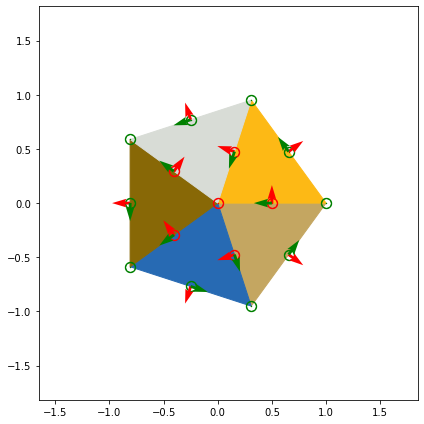

In [74]:
all_colors = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
colors = sample(all_colors, triangles_s.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("equal")

for index, triangle in enumerate(tqdm(triangles_s[:])):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)
    
for idx, point in enumerate(tqdm(points)):
    
    if vertex_maker_is_boundary[idx] == 0:
        color = "red"
    else:
        color = "green"
    ax.scatter(point[0], point[1], color=color, lw=10, s=2)
    
    if is_middle[idx] == True:
        ax.quiver(point[0], point[1], global_elem_normal[idx][0], global_elem_normal[idx][1], color="red", scale=21)
        ax.quiver(point[0], point[1], global_elem_tangential[idx][0], global_elem_tangential[idx][1], color="green", scale=21)
    
if not True:

    for idx, elem in enumerate(triangles):
    #     continue
        for j in range(6):
            if is_middle[elem[j]] == False:
                continue
            ax.quiver(points[elem[j]][0], points[elem[j]][1], elem_tangential[idx,j,0], elem_tangential[idx,j,1], color="green", scale=21)
            ax.quiver(points[elem[j]][0], points[elem[j]][1], elem_normal[idx,j,0], elem_normal[idx,j,1], color="red", scale=21)

        
    
ax.set_xlim([points[:, 0].min()-1, points[:, 0].max()+1])
ax.set_ylim([points[:, 1].min()-1, points[:, 1].max()+1])

fig.tight_layout()
plt.tight_layout()

plt.show()

In [75]:
tx = np.linspace(-1.5, 1.5, 1000)
ty = np.linspace(-1.5, 1.5, 1000)
mx, my = np.meshgrid(tx, ty, indexing="ij")

In [78]:
test_fn = x*y

test_fn_x = sympy.diff(test_fn, x)
test_fn_y = sympy.diff(test_fn, y)

test_fn_xx = sympy.diff(test_fn, x, x)
test_fn_xy = sympy.diff(test_fn, x, y)
test_fn_yy = sympy.diff(test_fn, y, y)

In [79]:
test_fn_vals = np.zeros((points.shape[0], 7))

for point_index, point in enumerate(points):

    test_fn_vals[point_index][0] = sympy.lambdify((x, y), test_fn)(*points[point_index])
    test_fn_vals[point_index][1] = sympy.lambdify((x, y), test_fn_x)(*points[point_index])
    test_fn_vals[point_index][2] = sympy.lambdify((x, y), test_fn_y)(*points[point_index])
    test_fn_vals[point_index][3] = sympy.lambdify((x, y), test_fn_xx)(*points[point_index])
    test_fn_vals[point_index][4] = sympy.lambdify((x, y), test_fn_xy)(*points[point_index])
    test_fn_vals[point_index][5] = sympy.lambdify((x, y), test_fn_yy)(*points[point_index])
    
    f_normal = global_elem_normal[point_index][0]*test_fn_x + \
               global_elem_normal[point_index][1]*test_fn_y
    
    test_fn_vals[point_index][6] = sympy.lambdify((x, y), f_normal)(*points[point_index])

In [80]:
mz = np.zeros_like(mx)

points_ = np.stack((mx, my)).transpose(1, 2, 0)

arg = (x_1, x_2, x_3, y_1, y_2, y_3)

for idx, (p_idx, __t_points__) in enumerate(zip(triangles, triangles_s)):
    
    print(f"\rTrinagle {idx}", end="", sep="")
        
    t_points = __t_points__[:3, :].copy()
    
    a = t_points[0] - t_points[1]
    b = t_points[0] - t_points[2]
    
    areas = np.abs(a[0]*b[1] - a[1]*b[0])
    
    del a, b
        
    a = (points_[...,] - t_points[0, None, None])
    b = (points_[...,] - t_points[1, None, None])
    c = (points_[...,] - t_points[2, None, None])
    
    area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
    area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
    area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])
    indices = np.where(np.isclose((area1+area2+area3), areas))
    
    del a, b, area1, area2, area3, areas
    
    CURRENT_BASIS = transform_basis(idx, t_points)
    
    on_1 = sympy.Float(0)
    on_2 = sympy.Float(0)
    on_3 = sympy.Float(0)
        
#   U
    on_1 += CURRENT_BASIS[0] * test_fn_vals[p_idx[0]][0]
    on_2 += CURRENT_BASIS[1] * test_fn_vals[p_idx[1]][0]
    on_3 += CURRENT_BASIS[2] * test_fn_vals[p_idx[2]][0]
    
#   U_x
    on_1 += CURRENT_BASIS[3] * test_fn_vals[p_idx[0]][1]
    on_2 += CURRENT_BASIS[4] * test_fn_vals[p_idx[1]][1]
    on_3 += CURRENT_BASIS[5] * test_fn_vals[p_idx[2]][1]

#   U_y
    on_1 += CURRENT_BASIS[6] * test_fn_vals[p_idx[0]][2]
    on_2 += CURRENT_BASIS[7] * test_fn_vals[p_idx[1]][2]
    on_3 += CURRENT_BASIS[8] * test_fn_vals[p_idx[2]][2]
    
#   U_xx
    on_1 += CURRENT_BASIS[9 ] * test_fn_vals[p_idx[0]][3]
    on_2 += CURRENT_BASIS[10] * test_fn_vals[p_idx[1]][3]
    on_3 += CURRENT_BASIS[11] * test_fn_vals[p_idx[2]][3]
    
#   U_xy
    on_1 += CURRENT_BASIS[12] * test_fn_vals[p_idx[0]][4]
    on_2 += CURRENT_BASIS[13] * test_fn_vals[p_idx[1]][4]
    on_3 += CURRENT_BASIS[14] * test_fn_vals[p_idx[2]][4]
    
#   U_yy
    on_1 += CURRENT_BASIS[15] * test_fn_vals[p_idx[0]][5]
    on_2 += CURRENT_BASIS[16] * test_fn_vals[p_idx[1]][5]
    on_3 += CURRENT_BASIS[17] * test_fn_vals[p_idx[2]][5]
        
#   U_n
    on_1 += CURRENT_BASIS[18] * test_fn_vals[p_idx[3]][6]
    on_2 += CURRENT_BASIS[19] * test_fn_vals[p_idx[4]][6]
    on_3 += CURRENT_BASIS[20] * test_fn_vals[p_idx[5]][6]
    
    total = on_1 + on_2 + on_3

    F = sympy.lambdify((x, y), total)
    
    MZ = F(mx, my)
    
    if isinstance(MZ, (int, float)):
        MZ = np.zeros_like(mx) + MZ
    
    mz[indices] = MZ[indices]

Trinagle 4

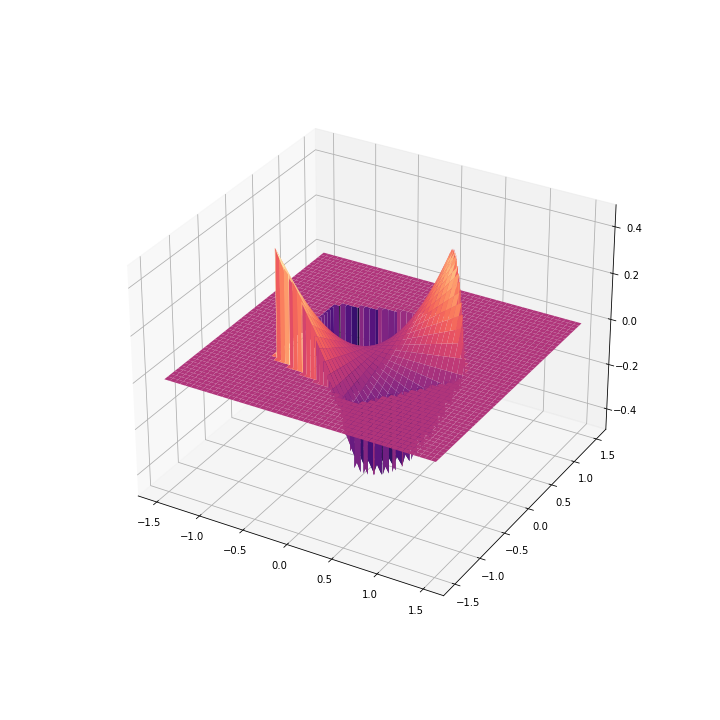

In [81]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(mx, my, mz, cmap="magma")
# ax.set_box_aspect((np.ptp(mx), np.ptp(my), 50*np.ptp(mz)))
plt.show()